In [1]:
#! python2
# -*- coding: utf-8 -*-
import pprint
import pymongo
import datetime
import numpy as np
from pymongo import MongoClient

from scipy import spatial
from scipy.sparse import isspmatrix, dok_matrix, csc_matrix
import sklearn.preprocessing

import pylab

import os

import progressbar

db_name = 'twitter'
col_name = 'after_process_replab'

In [2]:
from sklearn import metrics
from sklearn.cluster import DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth
# from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

from igraph import *
import igraph
import math
from operator import itemgetter



In [3]:
class MyPrettyPrinter(pprint.PrettyPrinter):
    def format(self, object, context, maxlevels, level):
        if isinstance(object, unicode):
            return (object.encode('thai'), True, False)
        return pprint.PrettyPrinter.format(self, object, context, maxlevels, level)

def go_print( input ):
    MyPrettyPrinter().pprint(input)
    # ppp = pprint.PrettyPrinter(indent=4)
    # ppp.pprint(input)
    return;

def get_midnight(time):
    return time.replace(minute=0, hour=0, second=0, microsecond=0)

def get_time_gap(time,hour_gap=1,min_gap=1):
    h = time.hour
    m = time.minute
    o_h = h/hour_gap*hour_gap
    o_m = m/min_gap*min_gap
    return time.replace(hour=o_h, minute=o_m, second=0, microsecond=0)

def get_week_year(time):
    return tuple([time.isocalendar()[0], time.isocalendar()[1]])

def get_thai_midnight(time):
    out = time + datetime.timedelta(hours=7)
    out = out.replace(minute=0, hour=0, second=0, microsecond=0) - datetime.timedelta(hours=7)
    return out

In [4]:
def get_sim(doc_a,doc_b):
    return 1 - spatial.distance.cosine(doc_a, doc_b)

In [5]:
a = [1, 1, 0, 0 ,0, 2]
b = [0, 0, 1, 2, 0, 0]
print cosine_similarity([a], [b])
print get_sim(a,b)

[[ 0.]]
0.0


In [6]:
if __name__ == '__main__':
    client = MongoClient()
    db = client[db_name]

    result = db[col_name].create_index([('ts', pymongo.ASCENDING)])
    cursor = db[col_name].find({}).sort([('ts', pymongo.ASCENDING)])
    

    date = []
    text = []
    all_doc = []

    bar = progressbar.ProgressBar(maxval=cursor.count()+1, widgets=[progressbar.Bar('#', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    data=1
    for doc in cursor:
        data += 1
        bar.update(data)
        
        ts = doc['ts']
        datetime_object = datetime.datetime.fromtimestamp(ts)
        if True:
#         if len(doc['hashtags']) != 0:
            buf = doc['nouns_nltk']
            for x in doc['hashtags']:
                if not x.lower() in buf:
                    buf.append(x.lower())
            all_doc.append(doc)
            date.append(datetime_object)
            text.append(' '.join(buf))
    bar.finish()
#     print len(date)

[########################################################################] 100%


In [7]:
def view_group(n_cluster, all_doc, doc_key, g_id):
        group = []
        for i in range(n_cluster):
            group.append([])
        
        for i in range( len(g_id) ):
            group[ g_id[i] ].append(all_doc[i][doc_key])
        return group

In [8]:
def split_day(date,text,all_doc):
    s_text = {}
    s_all_doc = {}
    for datetime_object in date:
        i = date.index(datetime_object)
        key = get_midnight(datetime_object)
        if not s_text.has_key(key):
            s_text[key] = []
            s_all_doc[key] = []
        s_text[key].append(text[i])
        s_all_doc[key].append(all_doc[i])
    return s_text,s_all_doc

def split_week(date,text,all_doc):
    s_text = {}
    s_all_doc = {}
    for datetime_object in date:
        i = date.index(datetime_object)
        key = get_week_year(datetime_object)
        if not s_text.has_key(key):
            s_text[key] = []
            s_all_doc[key] = []
        s_text[key].append(text[i])
        s_all_doc[key].append(all_doc[i])
    return s_text,s_all_doc


In [9]:
s_text,s_all_doc = split_day(date,text,all_doc)

In [10]:
print s_text.keys()

[datetime.datetime(2011, 11, 29, 0, 0), datetime.datetime(2011, 7, 18, 0, 0), datetime.datetime(2012, 6, 5, 0, 0), datetime.datetime(2012, 10, 8, 0, 0), datetime.datetime(2009, 8, 4, 0, 0), datetime.datetime(2012, 5, 28, 0, 0), datetime.datetime(2012, 9, 25, 0, 0), datetime.datetime(2012, 8, 26, 0, 0), datetime.datetime(2012, 11, 24, 0, 0), datetime.datetime(2012, 10, 10, 0, 0), datetime.datetime(2012, 6, 9, 0, 0), datetime.datetime(2011, 8, 20, 0, 0), datetime.datetime(2011, 12, 19, 0, 0), datetime.datetime(2011, 9, 15, 0, 0), datetime.datetime(2011, 1, 27, 0, 0), datetime.datetime(2011, 8, 24, 0, 0), datetime.datetime(2012, 5, 8, 0, 0), datetime.datetime(2012, 9, 13, 0, 0), datetime.datetime(2012, 7, 31, 0, 0), datetime.datetime(2012, 8, 22, 0, 0), datetime.datetime(2012, 11, 4, 0, 0), datetime.datetime(2012, 10, 27, 0, 0), datetime.datetime(2012, 5, 4, 0, 0), datetime.datetime(2011, 9, 27, 0, 0), datetime.datetime(2012, 12, 12, 0, 0), datetime.datetime(2012, 7, 3, 0, 0), datetime.da

In [11]:
i = 3
sample = []
ts = 1349689576
datetime_o = datetime.datetime.fromtimestamp(ts)
k = get_midnight(datetime_o)

sample = s_text[k]
sample_doc = s_all_doc[k]

# print sample

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf = tf_vectorizer.fit_transform(sample)
feature_names = tf_vectorizer.get_feature_names()
print feature_names
# print '\n\n tf-idf'
# tfidf_vectorizer_2 = TfidfVectorizer(max_df=0.95, min_df=2)
# tf2 = tfidf_vectorizer_2.fit_transform(sample)
# print tf2
test = cosine_similarity(tf)
test2 = cosine_distances(tf)

# for sim in test[0]:
#     if sim >= 0.1:
#         print sim, test[0].tolist().index(sim)
# print len(test)

print test[0]
print test2[0]

[u'america', u'amp', u'appl', u'bank', u'bbva', u'berkeley', u'blog', u'broken', u'california', u'call', u'capit', u'car', u'card', u'care', u'challeng', u'concert', u'congratul', u'cut', u'day', u'director', u'emm', u'fan', u'fiat', u'ford', u'forex', u'friend', u'ft', u'fxstreetnew', u'game', u'haha', u'health', u'hollywood', u'hope', u'jennif', u'jersey', u'kid', u'kurt', u'lopez', u'marathon', u'mascot', u'matheni', u'max', u'mazda', u'mazda3', u'minut', u'news', u'night', u'note', u'panther', u'peopl', u'point', u'post', u'power', u'rb', u'regul', u'rt', u'runner', u'sale', u'season', u'shirt', u'sporti', u'stadium', u'stock', u'studi', u'subaru', u'suzuki', u'system', u'team', u'test', u'time', u'today', u'tomorrow', u'univers', u'video', u'volkswagen', u'volvo', u'vote', u'wait', u'wash', u'week', u'win', u'work', u'wow', u'yale', u'yamaha', u'yandel', u'year']
[ 1.          0.          1.          0.          0.          0.          0.
  0.          0.          0.          0.  

In [12]:
print tf[0]
# print feature_names[165]
print sample

  (0, 84)	1
[u'aaron twitcon wayn zoooom yamaha', u'wise choic power play call rb', u'yamaha sound projector deal sound projector', u'admiss today watercolor societi exhibit bank credit card #free', u'ha gustado v\xeddeo jennif floor ft pitbul parodi awesom #37).', u'blame model hollywood stripper booti rack wow brain berkeley #novacane #frankocean', u'tiger suzuki trade haunt', u'bmw volvo deliveri fli pick car factori appl china deliveri', u'maruti suzuki wagon hatchback mileag kmpl', u'video fifa team path power liga bbva beast #6', u'ibra psg brace minut fiat', u'martin jennif wison amp yandel kovideo blog', u'bank america stadium carolina panther', u'qb rb point', u'build team year bank marathon rais fund', u'support afford duc lol', u'jennif hemlin headlin week', u'handgun area tonight gilman berkeley area gilman berkeley', u'pre pt pt studi mac dre volkswagen doe', u'bank america mafia', u'rb', u'suzuki sore tomorrow #nats #stlcards #nlds', u'call matheni ipitch count suzuki cur

In [13]:
# print test[0]
# test2 = StandardScaler().fit_transform(test)
# print test2[0]
print len(test2)
# print test2[479]

132


In [14]:
def find_centroid_score(tf,group_member,feature_names):
    centroid_list = []
    centroid_word_list = []
    score_list = []
    i = 0
    for group in group_member:
        count = np.zeros(len(feature_names))
        for member in group:
            count += tf[member].toarray()[0]
        centroid = count / len(group)
        centroid_list.append(centroid)
        
        centroid_word = []
        for word_index in range(len(feature_names)):
            if count[word_index] != 0 and centroid[word_index] > 0.5:
                word_data = '%.5f' % centroid[word_index] +' '+str(feature_names[word_index])
                centroid_word.append(word_data)
        centroid_word_list.append( sorted(centroid_word, reverse  = True))
        print i,':',sorted(centroid_word, reverse  = True)
                
        sum_sim = 0
        for member in group:
            m_tf = tf[member].toarray()[0]
            sum_sim += get_sim(m_tf,centroid)
        score = sum_sim/len(group)
        score_list.append(score)
        
        i +=1
    return centroid_list, centroid_word_list, score_list

In [15]:
def dbscan(test):
    # Compute DBSCAN
    cluster = DBSCAN(eps=0.3, min_samples=3,metric='precomputed').fit(test)
    # distance <= eps
    core_samples_mask = np.zeros_like(cluster.labels_, dtype=bool)
    core_samples_mask[cluster.core_sample_indices_] = True
    labels = cluster.labels_
    
#     print cluster.core_sample_indices_

    print labels
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print('Estimated number of clusters: %d' % n_clusters_)
    if n_clusters_>1:
        print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(test, labels))
        
    group = []
    for i in range(n_clusters_+1):
        group.append([])
    index = 0
    for i in labels:
        group[i].append(index)
        index += 1
    
    group = group[:-1]
    # for i in range(n_clusters_):
    #     print len(group[i])

    return group, labels, n_clusters_

In [16]:
group, labels, n_clusters_ = dbscan(test2)
i = 0
for mem in group:
    print i,mem
    i += 1

[ 0 -1  0 -1  7 -1  1 -1  1 -1  2 -1  3  4 -1 -1  7  5 -1  3  4  1 -1  6  6
  6  3  6  6  6  6  6  6 -1 -1 -1  7  3  1  7 -1  4  8  0  9 -1 -1  3 -1 -1
  4 -1  7 -1  2 -1 -1 -1  4  7  5 -1  3 -1  5 -1  7 -1  7  9  7  5 -1 -1 -1
 -1  7  0 -1 -1  2  3 -1  7 -1 -1 -1  0 -1 -1 -1 -1  5  0 -1  7  7 -1 -1  8
 -1  7  7 -1 -1  2 -1 -1  8  9  0 -1 -1 -1  3 -1 -1  7 -1 -1 -1 -1 -1 -1 -1
 -1 -1  7 -1 -1 -1 -1]
Estimated number of clusters: 10
Silhouette Coefficient: 0.294
0 [0, 2, 43, 77, 87, 93, 110]
1 [6, 8, 21, 38]
2 [10, 54, 80, 105]
3 [12, 19, 26, 37, 47, 62, 81, 114]
4 [13, 20, 41, 50, 58]
5 [17, 60, 64, 71, 92]
6 [23, 24, 25, 27, 28, 29, 30, 31, 32]
7 [4, 16, 36, 39, 52, 59, 66, 68, 70, 76, 83, 95, 96, 101, 102, 117, 127]
8 [42, 99, 108]
9 [44, 69, 109]


In [17]:
group_2 = view_group(n_clusters_+1 , sample_doc, "topic", labels)
group_2 = group_2[:-1]
x = 0
for i in group_2:
    print x,':',i
    x += 1

0 : [u'Lyrics', u'', u'other topics', u'Spare parts - For sale', u'User comments', u'Clothing', u'']
1 : [u'', u'Suzuki Wagon', u'', u'']
2 : [u'fiat is small, slow', u'photos / videos', u'test drive', u'owners comments/mention on their fiat']
3 : [u'Bofa Stadium - Panthers', u'Hate - Opinions', u'Geotag / Checking In', u'Bofa Stadium - Panthers', u'Geotag / Checking In', u'Goodwill Initiatives - Troops', u'Vacancy ', u'other topics']
4 : [u'', u'', u'', u'', u'']
5 : [u'', u'', u'', u'', u'UC Berkeley research']
6 : [u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon']
7 : [u'Fans Opinions: songs-videos', u'News about JL', u'Gossip: JL and her kids', u'Comments about her age', u'Gossip: JL and her kids', u'Gossip: JL and her kids', u'Commercials', u'Comments about JL', u'Gossip: JL and her kids', u'Gossip: 

In [18]:
centroid_list, centroid_word_list, score_list = find_centroid_score(tf,group,feature_names)

0 : ['1.28571 yamaha']
1 : ['1.00000 suzuki']
2 : ['1.50000 fiat']
3 : ['1.00000 bank', '0.62500 america']
4 : ['1.00000 rb']
5 : ['1.20000 berkeley']
6 : ['1.00000 runner', '1.00000 marathon', '1.00000 congratul', '1.00000 bank']
7 : ['1.05882 jennif', '0.76471 lopez']
8 : ['1.00000 univers']
9 : ['1.33333 mazda', '0.66667 mazda3']


In [19]:
#AffinityPropagation
def aff_cluster(test):
    # Compute DBSCAN
    cluster = AffinityPropagation(affinity='euclidean').fit(test)
    cluster_centers_indices = cluster.cluster_centers_indices_
    labels = cluster.labels_
    print cluster_centers_indices
#     print labels

    # print labels
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels))
#     print('Estimated number of clusters: %d' % n_clusters_)
        
    group = []
    for i in range(n_clusters_):
        group.append([])
    index = 0
    for i in labels:
        group[i].append(index)
        index += 1
        
    regroup = []
    relabel = []
    index = 0
    for mem in group:
        if len(mem) >= 3:
            regroup.append(mem)
            relabel.append(index)
#             print index
        index += 1
    
    new_label = []
    for i in labels:
        if i in relabel:
            new_label.append(relabel.index(i))
        else:
            new_label.append(-1)
    # for i in range(n_clusters_):
    #     print len(group[i])
    print new_label
    n_clusters_ = len(set(new_label))
    print('Estimated number of clusters: %d' % n_clusters_)

    return regroup, new_label, n_clusters_

In [20]:
group, labels, n_clusters_ = aff_cluster(tf)
i = 0
for mem in group:
    print i,mem
    i += 1

[  2   6  15  20  26  30  36  39  40  61  76  80  82 109 117 121 123 131]
[0, 3, 0, 4, 6, 2, 1, 2, 1, 2, 2, 6, 4, 3, 4, 2, 6, 10, 2, 4, 3, 1, 1, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 9, -1, 2, -1, 4, 1, 6, -1, 3, 2, 0, 2, 2, 2, 4, 2, 2, 3, 2, 7, 2, 2, 8, 2, 4, 3, 7, 2, -1, 4, 3, 2, 2, 9, 2, 9, 8, 7, 2, 2, 1, 2, 6, 7, 0, 2, 2, -1, 4, -1, 6, 1, 2, 2, 0, 2, 3, 2, 2, 2, 0, 2, 6, 9, 2, 3, 2, 2, 9, 9, 2, 2, 2, 2, 2, 2, 8, 0, 4, 0, 2, 4, 2, 2, 9, 2, 10, 2, -1, -1, -1, 2, 2, -1, 9, 2, 2, 2, 10]
Estimated number of clusters: 12
0 [0, 2, 43, 77, 87, 93, 110, 112]
1 [6, 8, 21, 22, 38, 73, 84]
2 [5, 7, 9, 10, 15, 18, 35, 42, 44, 45, 46, 48, 49, 51, 53, 54, 56, 60, 64, 65, 67, 71, 72, 74, 78, 79, 85, 86, 88, 90, 91, 92, 94, 97, 99, 100, 103, 104, 105, 106, 107, 108, 113, 115, 116, 118, 120, 124, 125, 128, 129, 130]
3 [1, 13, 20, 41, 50, 58, 63, 89, 98]
4 [3, 12, 14, 19, 26, 37, 47, 57, 62, 81, 111, 114]
5 [23, 24, 25, 27, 28, 29, 30, 31, 32]
6 [4, 11, 16, 39, 75, 83, 95]
7 [52, 59, 70, 76]
8 [55, 69, 109]


In [21]:
group_2 = view_group(n_clusters_ , sample_doc, "topic", labels)
x = 0
for i in group_2:
    print x,':',i
    x += 1

0 : [u'Lyrics', u'', u'other topics', u'Spare parts - For sale', u'User comments', u'Clothing', u'', u'For sale']
1 : [u'', u'Suzuki Wagon', u'', u'', u'', u'', u'S clients services by other companies']
2 : [u'', u'other topics', u'Sports sponsors', u'fiat is small, slow', u'User comments', u'User Photos', u'Sports sponsors', u"(Student's Study) Students Translates Rap Lyrics", u'Accident', u'', u'', u'Top List', u'', u'other topics', u'Students', u'photos / videos', u'', u'', u'', u'Sports sponsors', u'', u'', u'', u'Pictures posted in social networks', u'Self-Driving Cars', u'For Sale', u'RBS Job offers', u'', u'RBS & HMG to steal from SMEs', u'', u'Conferences & Talks', u'UC Berkeley research', u'Gossip: JL and her kids', u'', u'Researchers Studies & Projects', u'fiat keeps cash on its balance sheet', u'RBS forex forecasts', u'Professors', u'owners comments/mention on their fiat', u'Check-in', u'fiat keeps cash on its balance sheet', u'Modules & Programs at Yale', u"(Student's Study

In [22]:
centroid_list, centroid_word_list, score_list = find_centroid_score(tf,group,feature_names)

0 : ['1.25000 yamaha']
1 : ['1.00000 suzuki']
2 : []
3 : ['1.00000 rb']
4 : ['1.00000 bank']
5 : ['1.00000 runner', '1.00000 marathon', '1.00000 congratul', '1.00000 bank']
6 : ['1.00000 jennif']
7 : ['1.00000 sporti', '1.00000 max', '1.00000 lopez', '1.00000 jersey', '1.00000 jennif', '1.00000 emm']
8 : ['1.33333 mazda', '0.66667 mazda3', '0.66667 ford']
9 : ['1.00000 lopez', '1.00000 jennif']
10 : ['1.33333 berkeley', '1.00000 day', '0.66667 peopl']


C:\Python27\Lib\site-packages\scipy\spatial\distance.py:505: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


In [23]:
def sparse_allclose(a, b, rtol=1e-5, atol=1e-8):
    """
    Version of np.allclose for use with sparse matrices
    """
    c = np.abs(a - b) - rtol * np.abs(b)
    # noinspection PyUnresolvedReferences
    return c.max() <= atol


def normalize(matrix):
    """
    Normalize the columns of the given matrix
    
    :param matrix: The matrix to be normalized
    :returns: The normalized matrix
    """
    return sklearn.preprocessing.normalize(matrix, norm="l1", axis=0)


def inflate(matrix, power):
    """
    Apply cluster inflation to the given matrix by raising
    each element to the given power.
    
    :param matrix: The matrix to be inflated
    :param power: Cluster inflation parameter
    :returns: The inflated matrix
    """
    if isspmatrix(matrix):
        return normalize(matrix.power(power))

    return normalize(np.power(matrix, power))


def expand(matrix, power):
    """
    Apply cluster expansion to the given matrix by raising
    the matrix to the given power.
    
    :param matrix: The matrix to be expanded
    :param power: Cluster expansion parameter
    :returns: The expanded matrix
    """
    if isspmatrix(matrix):
        return matrix ** power

    return np.linalg.matrix_power(matrix, power)


def add_self_loops(matrix, loop_value):
    """
    Add self-loops to the matrix by setting the diagonal
    to loop_value
    
    :param matrix: The matrix to add loops to
    :param loop_value: Value to use for self-loops
    :returns: The matrix with self-loops
    """
    shape = matrix.shape
    assert shape[0] == shape[1], "Error, matrix is not square"

    if isspmatrix(matrix):
        new_matrix = matrix.todok()
    else:
        new_matrix = matrix.copy()

    for i in range(shape[0]):
        new_matrix[i, i] = loop_value

    if isspmatrix(matrix):
        return new_matrix.tocsc()

    return new_matrix


def prune(matrix, threshold):
    """
    Prune the matrix so that very small edges are removed
    
    :param matrix: The matrix to be pruned
    :param threshold: The value below which edges will be removed
    :returns: The pruned matrix
    """
    if isspmatrix(matrix):
        pruned = dok_matrix(matrix.shape)
        pruned[matrix >= threshold] = matrix[matrix >= threshold]
        pruned = pruned.tocsc()
    else:
        pruned = matrix.copy()
        pruned[pruned < threshold] = 0

    return pruned


def converged(matrix1, matrix2):
    """
    Check for convergence by determining if 
    matrix1 and matrix2 are approximately equal.
    
    :param matrix1: The matrix to compare with matrix2
    :param matrix2: The matrix to compare with matrix1
    :returns: True if matrix1 and matrix2 approximately equal
    """
    if isspmatrix(matrix1) or isspmatrix(matrix2):
        return sparse_allclose(matrix1, matrix2)

    return np.allclose(matrix1, matrix2)


def iterate(matrix, expansion, inflation):
    """
    Run a single iteration (expansion + inflation) of the mcl algorithm
    
    :param matrix: The matrix to perform the iteration on
    :param expansion: Cluster expansion factor
    :param inflation: Cluster inflation factor
    """
    # Expansion
    matrix = expand(matrix, expansion)

    # Inflation
    matrix = inflate(matrix, inflation)

    return matrix


def get_clusters(matrix):
    """
    Retrieve the clusters from the matrix
    
    :param matrix: The matrix produced by the MCL algorithm
    :returns: A list of tuples where each tuple represents a cluster and
              contains the indices of the nodes belonging to the cluster
    """
    if not isspmatrix(matrix):
        # cast to sparse so that we don't need to handle different 
        # matrix types
        matrix = csc_matrix(matrix)

    # get the attractors - non-zero elements of the matrix diagonal
    attractors = matrix.diagonal().nonzero()[0]

    # somewhere to put the clusters
    clusters = set()

    # the nodes in the same row as each attractor form a cluster
    for attractor in attractors:
        cluster = tuple(matrix.getrow(attractor).nonzero()[1].tolist())
        clusters.add(cluster)

    return sorted(list(clusters))


def run_mcl(matrix, expansion=2, inflation=2, loop_value=1,
            iterations=100, pruning_threshold=0.001, pruning_frequency=1,
            convergence_check_frequency=1, verbose=False):
    """
    Perform MCL on the given similarity matrix
    
    :param matrix: The similarity matrix to cluster
    :param expansion: The cluster expansion factor
    :param inflation: The cluster inflation factor
    :param loop_value: Initialization value for self-loops
    :param iterations: Maximum number of iterations
           (actual number of iterations will be less if convergence is reached)
    :param pruning_threshold: Threshold below which matrix elements will be set
           set to 0
    :param pruning_frequency: Perform pruning every 'pruning_frequency'
           iterations. 
    :param convergence_check_frequency: Perform the check for convergence
           every convergence_check_frequency iterations
    :param verbose: Print extra information to the console
    :returns: The final matrix
    """
    print("-" * 50)
    print("MCL Parameters")
    print("Expansion: {}".format(expansion))
    print("Inflation: {}".format(inflation))
    if pruning_threshold > 0:
        print("Pruning threshold: {}, frequency: {} iteration{}".format(
            pruning_threshold, pruning_frequency, "s" if pruning_frequency > 1 else ""))
    else:
        print("No pruning")
    print("Convergence check: {} iteration{}".format(
        convergence_check_frequency, "s" if convergence_check_frequency > 1 else ""))
    print("Maximum iterations: {}".format(iterations))
    print("{} matrix mode".format("Sparse" if isspmatrix(matrix) else "Dense"))
    print("-" * 50)

    # Initialize self-loops
    if loop_value > 0:
        matrix = add_self_loops(matrix, loop_value)

    # Normalize
    matrix = normalize(matrix)

    # iterations
    for i in range(iterations):
        print("Iteration {}".format(i + 1))

        # store current matrix for convergence checking
        last_mat = matrix.copy()

        # perform MCL expansion and inflation
        matrix = iterate(matrix, expansion, inflation)

        # prune
        if pruning_threshold > 0 and i % pruning_frequency == pruning_frequency - 1:
            print("Pruning")
            matrix = prune(matrix, pruning_threshold)

        # Check for convergence
        if i % convergence_check_frequency == convergence_check_frequency - 1:
            print("Checking for convergence")
            if converged(matrix, last_mat):
                print("Converged after {} iteration{}".format(i + 1, "s" if i > 0 else ""))
                break

    print("-" * 50)

    return matrix

In [24]:
mcl = run_mcl(test,inflation = 1.5)
cluster = get_clusters(mcl)

--------------------------------------------------
MCL Parameters
Expansion: 2
Inflation: 1.5
Pruning threshold: 0.001, frequency: 1 iteration
Convergence check: 1 iteration
Maximum iterations: 100
Dense matrix mode
--------------------------------------------------
Iteration 1
Pruning
Checking for convergence
Iteration 2
Pruning
Checking for convergence
Iteration 3
Pruning
Checking for convergence
Iteration 4
Pruning
Checking for convergence
Iteration 5
Pruning
Checking for convergence
Iteration 6
Pruning
Checking for convergence
Iteration 7
Pruning
Checking for convergence
Iteration 8
Pruning
Checking for convergence
Iteration 9
Pruning
Checking for convergence
Iteration 10
Pruning
Checking for convergence
Iteration 11
Pruning
Checking for convergence
Iteration 12
Pruning
Checking for convergence
Iteration 13
Pruning
Checking for convergence
Iteration 14
Pruning
Checking for convergence
Iteration 15
Pruning
Checking for convergence
Iteration 16
Pruning
Checking for convergence
Iterat

In [25]:
# for py 3.xx 
# import markov_clustering as mc

# mcl = mc.run_mcl(test,inflation = 1.5)           # run MCL with default parameters
# cluster = mc.get_clusters(mcl) 

In [26]:
num = 0
labels = [0]*len(test)
g_index = 0
for mem in cluster:
    for i in mem:
        labels[i] = g_index
    g_index += 1
n_clusters_ = len(cluster)

In [27]:
print labels

[0, 1, 0, 2, 3, 4, 5, 6, 5, 7, 8, 3, 2, 1, 2, 9, 3, 4, 10, 2, 1, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4, 7, 3, 2, 5, 3, 4, 1, 11, 0, 12, 13, 14, 2, 3, 2, 1, 13, 3, 15, 8, 12, 16, 2, 1, 3, 4, 5, 2, 1, 4, 7, 3, 15, 3, 12, 3, 4, 17, 5, 13, 3, 3, 0, 10, 12, 8, 2, 18, 3, 5, 19, 4, 0, 6, 1, 4, 10, 4, 0, 20, 3, 3, 21, 1, 11, 8, 3, 3, 1, 22, 8, 10, 10, 11, 12, 0, 2, 0, 3, 2, 10, 8, 3, 23, 4, 13, 14, 14, 3, 18, 24, 3, 3, 25, 6, 15, 4]


In [28]:
group_2 = view_group(n_clusters_ , sample_doc, "topic", labels)
x = 0
for i in group_2:
    print x,':',i
    x += 1

0 : [u'Lyrics', u'', u'other topics', u'Spare parts - For sale', u'User comments', u'Clothing', u'', u'For sale']
1 : [u'', u'', u'', u'', u'', u'', u'', u'RBS economic analysis', u'', u'RBS forex forecasts']
2 : [u'Bofa Credit Card', u'Bofa Stadium - Panthers', u'Bofa Chicago Marathon', u'Hate - Opinions', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Geotag / Checking In', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Chicago Marathon', u'Bofa Stadium - Panthers', u'Geotag / Checking In', u'', u'Bofa Chicago Marathon', u'Goodwill Initiatives - Troops', u'Vacancy ', u'Stock Ratings', u'other topics']
3 : [u'Fans Opinions: songs-videos', u'News about JL', u'News about JL', u'Song-Video: Wisin Yandel ft JL Follow the leader', u'Gossip: JL and her kids', u'Comments about her age', u'Top List', u'Gossip: JL and her kids', u'Gossip: JL and her kids', u'Commercials', 

In [29]:
centroid_list, centroid_word_list, score_list = find_centroid_score(tf,group,feature_names)

0 : ['1.25000 yamaha']
1 : ['1.00000 suzuki']
2 : []
3 : ['1.00000 rb']
4 : ['1.00000 bank']
5 : ['1.00000 runner', '1.00000 marathon', '1.00000 congratul', '1.00000 bank']
6 : ['1.00000 jennif']
7 : ['1.00000 sporti', '1.00000 max', '1.00000 lopez', '1.00000 jersey', '1.00000 jennif', '1.00000 emm']
8 : ['1.33333 mazda', '0.66667 mazda3', '0.66667 ford']
9 : ['1.00000 lopez', '1.00000 jennif']
10 : ['1.33333 berkeley', '1.00000 day', '0.66667 peopl']


In [30]:
def find_eps(test):
    eps_set = []
    n = len(test)
    k = min(2,n-1)
    for i in range(n):
        eps_set.append(sorted(test[i])[2])
        
    return sorted(eps_set)

In [31]:
x = find_eps(test2)
x

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.2204460492503131e-16,
 2.2204460492503131e-16,
 2.2204460492503131e-16,
 2.2204460492503131e-16,
 2.2204460492503131e-16,
 2.2204460492503131e-16,
 2.2204460492503131e-16,
 2.2204460492503131e-16,
 0.07417990022744847,
 0.095465966266709112,
 0.095465966266709112,
 0.095465966266709112,
 0.10557280900008414,
 0.18350341907227397,
 0.18350341907227397,
 0.18350341907227397,
 0.18350341907227397,
 0.2254033307585166,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.29289321881345254,
 0.33333333333333315,
 0.35450277563209709,
 0.36754446796632423,
 0.42264973081037416,
 0.422649730810374

In [32]:
np.diff(x)

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   2.22044605e-16,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         7.41799002e-02,   2.12860660e-02,   0.00000000e+00,
         0.00000000e+00,   1.01068427e-02,   7.79306101e-02,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.18999117e-02,   6.74898881e-02,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

In [33]:
a = [1,1,2,2,3,3]
b = [1,1,3,3,2,2]
metrics.adjusted_rand_score(a,b)

1.0

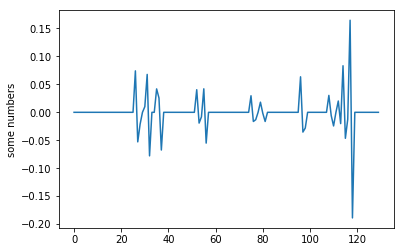

In [34]:
import matplotlib.pyplot as plt
y=np.diff(np.diff(x))
plt.plot(y)
plt.ylabel('some numbers')
plt.show()

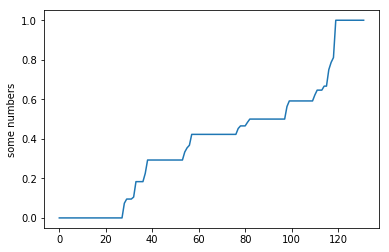

In [35]:
import matplotlib.pyplot as plt
plt.plot(x)
plt.ylabel('some numbers')
plt.show()

In [36]:
ts = 1353459600
datetime_o = datetime.datetime.fromtimestamp(ts)
k = get_midnight(datetime_o)

sample = s_text[k]
sample_doc = s_all_doc[k]

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2)
tf = tf_vectorizer.fit_transform(sample)
feature_names = tf_vectorizer.get_feature_names()

test = cosine_similarity(tf)
test2 = cosine_distances(tf)



In [37]:
from scipy import stats
y = [i for i in range(len(x))]
stats.linregress(y,x)

LinregressResult(slope=0.0074517709742943101, intercept=-0.09212201941578263, rvalue=0.96295527933511327, pvalue=7.356257075441505e-76, stderr=0.00018302063967087019)

In [38]:
len(test2)

535

In [39]:
1.0/535

0.001869158878504673